# Majority Baseline vs Logistic Regression

In [1]:
import numpy as np
from pathlib import Path


In [2]:
DATA_PATH = Path('diabetes_012_health_indicators_BRFSS2015.csv')

raw = np.loadtxt(DATA_PATH, delimiter=',', skiprows=1)
X = raw[:, 1:]
y = (raw[:, 0] > 0).astype(float)

print(f'Total samples: {len(X)} | Features: {X.shape[1]}')
print(f'Positive class share: {y.mean():.3f}')


Total samples: 253680 | Features: 21
Positive class share: 0.158


In [3]:
rng = np.random.default_rng(42)
indices = np.arange(len(X))
rng.shuffle(indices)

n = len(indices)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1.0

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print(f'Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}')


Train size: 152208, Val size: 50736, Test size: 50736


In [4]:
neg = np.sum(y_train == 0)
pos = len(y_train) - neg
majority_class = 1 if pos > neg else 0

y_test_majority = np.full_like(y_test, majority_class)
majority_acc = (y_test_majority == y_test).mean()

print(f'Majority class (train split): {majority_class}')
print(f'Majority baseline test accuracy: {majority_acc:.4f}')


Majority class (train split): 0
Majority baseline test accuracy: 0.8422


In [5]:
class LogisticRegressionGD:
    def __init__(self, lr=0.05, epochs=200, reg=0.0):
        self.lr = lr
        self.epochs = epochs
        self.reg = reg
        self.w = None
        self.b = 0.0

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for _ in range(self.epochs):
            linear = X @ self.w + self.b
            preds = self._sigmoid(linear)
            error = preds - y

            grad_w = (X.T @ error) / n_samples + self.reg * self.w
            grad_b = error.mean()

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
        return self

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [6]:
learning_rates = [0.03, 0.05]
regs = [0.0, 0.001]
epochs_list = [200, 400]

best_val_acc = -1.0
best_params = None
best_model = None

print('Running compact grid search for logistic regression...')
for lr in learning_rates:
    for reg in regs:
        for epochs in epochs_list:
            model = LogisticRegressionGD(lr=lr, reg=reg, epochs=epochs)
            model.fit(X_train, y_train)
            val_preds = model.predict(X_val)
            val_acc = (val_preds == y_val).mean()
            print(f'lr={lr:.3f}, reg={reg:.4f}, epochs={epochs} -> val acc={val_acc:.4f}')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, reg, epochs)
                best_model = model

print('Best hyperparameters by validation accuracy:')
print(f'lr={best_params[0]:.3f}, reg={best_params[1]:.4f}, epochs={best_params[2]}')
print(f'Validation accuracy: {best_val_acc:.4f}')

val_proba = best_model.predict_proba(X_val)
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_thresh_acc = -1.0

for t in thresholds:
    preds_t = (val_proba >= t).astype(int)
    acc_t = (preds_t == y_val).mean()
    if acc_t > best_thresh_acc:
        best_thresh_acc = acc_t
        best_thresh = t

print(f'Best threshold on validation set: {best_thresh:.3f} (val acc={best_thresh_acc:.4f})')

train_preds = best_model.predict(X_train, threshold=best_thresh)
val_preds = best_model.predict(X_val, threshold=best_thresh)
test_preds = best_model.predict(X_test, threshold=best_thresh)

train_acc = (train_preds == y_train).mean()
val_acc = (val_preds == y_val).mean()
logistic_test_acc = (test_preds == y_test).mean()

print('Logistic regression accuracy with tuned threshold:')
print(f'Train: {train_acc:.4f}')
print(f'Val  : {val_acc:.4f}')
print(f'Test : {logistic_test_acc:.4f}')


Running compact grid search for logistic regression...
lr=0.030, reg=0.0000, epochs=200 -> val acc=0.8465
lr=0.030, reg=0.0000, epochs=400 -> val acc=0.8492
lr=0.030, reg=0.0010, epochs=200 -> val acc=0.8463
lr=0.030, reg=0.0010, epochs=400 -> val acc=0.8492
lr=0.050, reg=0.0000, epochs=200 -> val acc=0.8487
lr=0.050, reg=0.0000, epochs=400 -> val acc=0.8497
lr=0.050, reg=0.0010, epochs=200 -> val acc=0.8486
lr=0.050, reg=0.0010, epochs=400 -> val acc=0.8496
Best hyperparameters by validation accuracy:
lr=0.050, reg=0.0000, epochs=400
Validation accuracy: 0.8497
Best threshold on validation set: 0.520 (val acc=0.8498)
Logistic regression accuracy with tuned threshold:
Train: 0.8477
Val  : 0.8498
Test : 0.8476


In [7]:
print('--- Summary ---')
print(f'Majority baseline test accuracy: {majority_acc:.4f}')
print(f'Logistic regression test accuracy (threshold={best_thresh:.3f}): {logistic_test_acc:.4f}')


--- Summary ---
Majority baseline test accuracy: 0.8422
Logistic regression test accuracy (threshold=0.520): 0.8476


## Correlation heatmap
Visualize how each BRFSS feature correlates with the diabetes indicator.

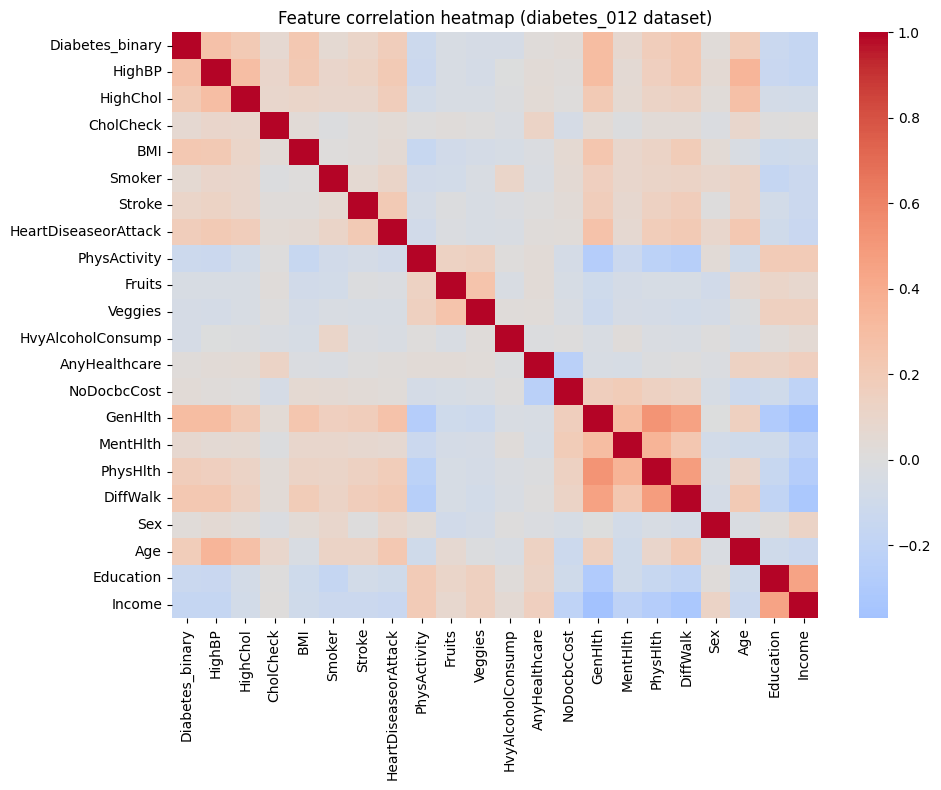

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = pd.read_csv(DATA_PATH)
corr_df = corr_df.rename(columns={corr_df.columns[0]: "Diabetes_binary"})

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Feature correlation heatmap (diabetes_012 dataset)")
plt.tight_layout()
plt.show()

## Evaluation metrics
Clear view of tuned threshold and core classification metrics.

In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import pandas as pd

# Predicted probabilities for ROC-AUC and plots
test_proba = best_model.predict_proba(X_test)

metrics = {
    "threshold": best_thresh,
    "accuracy": accuracy_score(y_test, test_preds),
    "precision": precision_score(y_test, test_preds, zero_division=0),
    "recall": recall_score(y_test, test_preds, zero_division=0),
    "f1": f1_score(y_test, test_preds, zero_division=0),
    "roc_auc": roc_auc_score(y_test, test_proba),
}

display(pd.DataFrame([metrics]))

cm = confusion_matrix(y_test, test_preds)
print("Confusion matrix (rows=true, cols=pred):", cm)

,threshold,accuracy,precision,recall,f1,roc_auc
0,0.52,0.847564,0.564929,0.148851,0.23562,0.817259


Confusion matrix (rows=true, cols=pred): [[41810   918]
 [ 6816  1192]]


## ROC / PR curves and confusion matrix

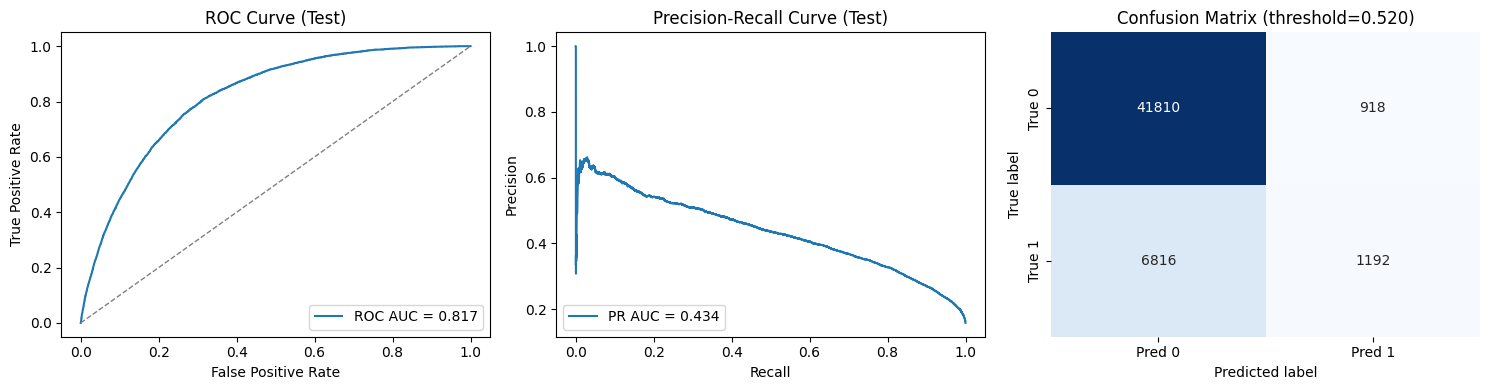

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, _ = roc_curve(y_test, test_proba)
precision, recall, _ = precision_recall_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
ax[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
ax[0].set_title('ROC Curve (Test)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
ax[1].set_title('Precision-Recall Curve (Test)')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')

cm = confusion_matrix(y_test, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax[2])
ax[2].set_title(f'Confusion Matrix (threshold={best_thresh:.3f})')
ax[2].set_xlabel('Predicted label')
ax[2].set_ylabel('True label')
plt.tight_layout()
plt.show()

## Training loss curve
Track logistic loss over epochs using the tuned hyperparameters.

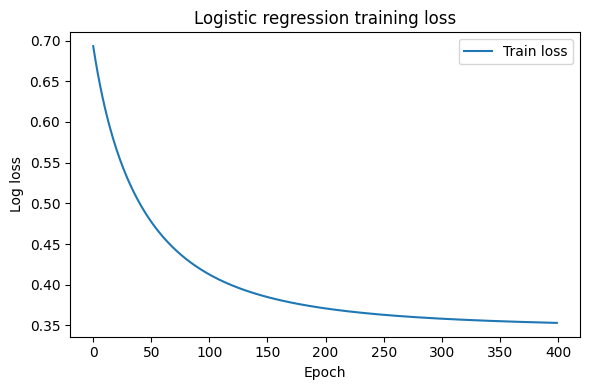

In [11]:
def compute_loss_curve(X, y, lr, reg, epochs):
    w = np.zeros(X.shape[1])
    b = 0.0
    losses = []
    for _ in range(epochs):
        linear = X @ w + b
        preds = 1.0 / (1.0 + np.exp(-linear))
        preds = np.clip(preds, 1e-8, 1 - 1e-8)
        loss = -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
        losses.append(loss)
        error = preds - y
        grad_w = (X.T @ error) / len(y) + reg * w
        grad_b = error.mean()
        w -= lr * grad_w
        b -= lr * grad_b
    return losses

loss_curve = compute_loss_curve(X_train, y_train, best_params[0], best_params[1], best_params[2])
plt.figure(figsize=(6, 4))
plt.plot(loss_curve, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.title('Logistic regression training loss')
plt.legend()
plt.tight_layout()
plt.show()